# Importo le librerie necessarie

In [75]:
import clip
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from scripts.pre_processing import metadata_list
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import  confusion_matrix, accuracy_score, recall_score, precision_score
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# Definizione della funzione Early_Stopping che permette di ottimizzare i parametri su quando interrompere l'addestramento

In [76]:
class EarlyStopping:
    # Classe per implementare l'early stopping durante l'addestramento del modello
    def __init__(self, patience=10, delta=0.005, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    # Metodo per resettare lo stato dell'early stopping
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            # Se non c'è miglioramento, incrementa il contatore
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("[INFO] Early stopping attivato - nessun miglioramento osservato.")


# Definisco un metodo per l'utilizzo di CUDA rispetto alla CPU per velocizzare le operazioni

In [77]:
def setup_device():
    """
    Imposta il dispositivo di calcolo (CPU, CUDA o MPS) in base alla disponibilità.
    :return: stringa che indica il dispositivo utilizzato
    """
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    print(f"[INFO] Dispositivo utilizzato: {device}")
    if device == "cuda":
        torch.cuda.empty_cache()
        print("Cache CUDA liberata!")
    return device


# Importo il dataset cycle_gan poichè contiene nella colonna target sia 0 che 1

La scelta di questo dataset è dovuta dal fatto che il nostro obiettivo è quello di indicare se l'immagine in input è reale o fake. Di conseguenza CLIP funziona solo se abbiamo un dataset con immagini sia reali che fake. Questo dataset rispetta tale condizione.

In [78]:
def get_datasets(metadata_list, index):
    if len(metadata_list) > index:
        return metadata_list[index]
    raise IndexError("L'indice specificato non è valido")

try:
    dataset_pro_gan = get_datasets(metadata_list, 5)  # Solo PRO-GAN
    print("[INFO] Dataset Pro-GAN:")
    print(dataset_pro_gan)
except IndexError as e:
    print(f"[ERRORE] {e}")

[INFO] Dataset Pro-GAN:
            filename                    image_path  target     category
0      img000851.jpg  st/horse2zebra/img000851.jpg       0  horse2zebra
1      img004163.jpg  st/horse2zebra/img004163.jpg       0  horse2zebra
2      img003305.jpg  st/horse2zebra/img003305.jpg       0  horse2zebra
3      img001548.jpg  st/horse2zebra/img001548.jpg       1  horse2zebra
4      img004940.jpg  st/horse2zebra/img004940.jpg       1  horse2zebra
...              ...                           ...     ...          ...
15205  img016350.jpg  st/photo2monet/img016350.jpg       0  photo2monet
15206  img011734.jpg  st/photo2monet/img011734.jpg       0  photo2monet
15207  img015011.jpg  st/photo2monet/img015011.jpg       0  photo2monet
15208  img014558.jpg  st/photo2monet/img014558.jpg       1  photo2monet
15209  img015042.jpg  st/photo2monet/img015042.jpg       0  photo2monet

[15210 rows x 4 columns]


# Estrazione degli embedding delle immagini tramite modello CLIP
Questo metodo estrae una rappresentazione vettoriale (embedding) con dimensione 512 per immagine, utilizzando il modello pre-addestrato CLIP. Carica l’immagine, la pre-processa e la passa al modello CLIP per ottenere un embedding normalizzato. Libera anche la cache CUDA per evitare memory leak se presente.

In [79]:

def get_image_embedding(img_path):
    try:
        image = Image.open(img_path).convert("RGB")


        image_tensor = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            embedding = model.encode_image(image_tensor)
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)

        # Libera memoria
        del image_tensor
        if device == "cuda":
            torch.cuda.empty_cache()

        return embedding.squeeze().cpu()

    except Exception as e:
        print(f"[ERRORE] {img_path}: {e}")
        return None

# Estrazione degli embedding testuali con CLIP
Elabora una stringa testuale, estratta dalla feature category, convertendola in un formato compatibile con il modello CLIP tramite tokenizzazione e embedding. La stringa viene trasformata in un tensore di input attraverso il tokenizer del modello, successivamente viene elaborata per ottenere una rappresentazione vettoriale (embedding) normalizzata, che ne cattura il significato semantico.

In [80]:
def get_text_embedding(text):

    # Tokenizza il testo e ottiene l'embedding
    text_tokenized = clip.tokenize([text]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(text_tokenized)
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    return embedding.squeeze().cpu()


# Dataset personalizzato per apprendimento multimodale (immagini + testo)
Classe custom per PyTorch che gestisce un dataset multimodale, restituendo triplette composte da embedding di immagine, embedding testuale della categoria e l’etichetta associata.

In [81]:
class MultimodalDataset:
    # Dataset personalizzato per gestire immagini e categorie testuali
    def __init__(self, img_embeddings, categories, category_embeddings, labels, indices, augment=False):
        self.img_embeddings = img_embeddings
        self.categories = categories
        self.category_embeddings = category_embeddings
        self.labels = labels
        self.indices = indices
        self.augment = augment
    # Metodo per verificare se il dataset è vuoto
    def __len__(self):
        return len(self.indices)
    # Metodo per ottenere un elemento del dataset
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img_emb = self.img_embeddings[real_idx]
        cat = self.categories[real_idx]
        txt_emb = self.category_embeddings[cat]
        label = self.labels[real_idx]
        return img_emb.float(), txt_emb.float(), label


# Rete neurale per la fusione di embedding di immagini e testo
Una rete che proietta separatamente gli embedding di immagine e testo in uno spazio comune di dimensione ridotta, li somma e applica la normalizzazione. Serve per apprendere una rappresentazione multimodale utile per triplet loss.

In [82]:
class ImageTextModel(nn.Module):
    def __init__(self, input_dim=512, output_dim=128):
        super().__init__()

        # Proiezioni diretta delle immagini
        self.image_proj = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Proiezioni diretta del testo
        self.text_proj = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Layer finale di normalizzazione
        self.layer_norm = nn.LayerNorm(output_dim)

        # Inizializzazione pesi
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # metodo per unire i vettori di embedding delle immagini e del testo
    def forward(self, image_emb, text_emb):
        # Proiezioni indipendenti
        img_proj = self.image_proj(image_emb)
        txt_proj = self.text_proj(text_emb)

        # Fusione tramite somma
        combined = img_proj + txt_proj

        # Normalizzazione finale
        return self.layer_norm(combined)



# Estrazione delle triplette (anchor, positive, negative) per triplet loss
Dati gli indici delle triplette prodotte dal miner, estrae i relativi embedding (anchor, positive, negative). Funziona sia nel caso in cui gli indici sono tuple o tensori.

In [83]:
def extract_triplets(miner_output, embeddings):

    if isinstance(miner_output, tuple):
        anchor_idx, positive_idx, negative_idx = miner_output
    else:
        if miner_output.nelement() == 0:
            return None, None, None
        anchor_idx, positive_idx, negative_idx = miner_output[:, 0], miner_output[:, 1], miner_output[:, 2]

    anchor = embeddings[anchor_idx]
    positive = embeddings[positive_idx]
    negative = embeddings[negative_idx]

    return anchor, positive, negative


# Visualizzazione dell’evoluzione della triplet loss
Crea un grafico che confronta la loss di training e validation nel corso delle epoche. Aiuta a valutare se il modello sta imparando efficacemente o va incontro ad overfitting.



In [84]:

def plot_triplet_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Plot delle loss
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)

    # Configurazione grafico
    plt.xlabel('Epoca')
    plt.ylabel('Triplet Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Mostra valori finali
    print(f"Loss finale - Training: {train_losses[-1]:.4f}, Validation: {val_losses[-1]:.4f}")

    plt.tight_layout()
    plt.show()


# Creazione di un dizionario per gli embedding sulle immagini

In [85]:
def load_dataset_and_embeddings(metadata_index, csv_path):

    # Carica il dataset e calcola gli embedding delle immagini
    dataset = get_datasets(metadata_list, metadata_index)
    # Verifica che il CSV esista
    print(f"[INFO] Immagini totali nel CSV: {len(dataset)}")
    # Controlla se il CSV contiene la colonna 'image_path' e 'target'
    embeddings_img, labels_img = [], []
    # Verifica che le colonne richieste siano presenti
    for idx, row in tqdm(dataset.iterrows(), total=len(dataset)):
        full_img_path = csv_path.parent / row['image_path']
        label = row['target']
        if full_img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            # estrae l'embedding dell'immagine
            emb = get_image_embedding(str(full_img_path))
            if emb is not None:
                # Aggiunge l'embedding e l'etichetta alla lista
                embeddings_img.append(emb)
                labels_img.append(label)

    # Verifica che siano stati estratti gli embedding
    X_img = torch.stack(embeddings_img)
    y_img = torch.tensor(labels_img)
    print(f"[INFO] Embedding immagini estratti: {len(X_img)}")
    return dataset, X_img, y_img


# Creazione di un dizionario per gli embedding di testo
L'obbiettivo di queste due funzioni è quello di associare ad ogni embedding estratto per l'immagine il corrispondente embedding estratto per il testo (category)


In [86]:
def extract_text_embeddings(dataset):

    category_embeddings = {}
    # Verifica che il dataset contenga la colonna 'category'
    if 'category' in dataset.columns:
        unique_categories = dataset['category'].dropna().unique()
        print("[INFO] Categorie trovate:")
        # Inizializza il dizionario per gli embedding delle categorie
        for cat in unique_categories:
            print(f" - {cat}")
            # chiama la funzione per ottenere l'embedding del testo
            emb = get_text_embedding(cat)
            category_embeddings[cat] = emb
        print(f"[INFO] Embedding testuali estratti: {len(category_embeddings)}")
    return category_embeddings

# Costruzione di DataLoader PyTorch per training, validation e test
Questo metodo seleziona solo le istanze del dataset con categoria valida e presente negli embedding testuali, effettua una suddivisione stratificata in set di training, validation e test, e costruisce i rispettivi DataLoader PyTorch per l'addestramento del modello.


In [87]:
def prepare_dataloaders(dataset, X_img, y_img, category_embeddings):


    valid_indices = [i for i in range(len(X_img)) if pd.notna(dataset.iloc[i]['category']) and dataset.iloc[i]['category'] in category_embeddings]
    X_img_valid = X_img[valid_indices]
    y_img_valid = y_img[valid_indices]
    categories_valid = [dataset.iloc[i]['category'] for i in valid_indices]

    # Split
    X_temp_idx = np.array(range(len(valid_indices)))
    y_temp = y_img_valid.numpy()
    train_idx, temp_idx, y_train, y_temp2 = train_test_split(X_temp_idx, y_temp, test_size=0.3, stratify=y_temp, random_state=42)
    val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp2, test_size=2/3, stratify=y_temp2, random_state=42)

    # Datasets
    train_dataset = MultimodalDataset(X_img_valid, categories_valid, category_embeddings, y_img_valid, train_idx, augment=False)
    val_dataset = MultimodalDataset(X_img_valid, categories_valid, category_embeddings, y_img_valid, val_idx, augment=False)
    test_dataset = MultimodalDataset(X_img_valid, categories_valid, category_embeddings, y_img_valid, test_idx, augment=False)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

# Addestramento del modello multimodale con triplet loss
Allena il modello ImageTextModel usando una triplet loss con miner semi-hard. Questo metodo identifica solo le triplette in cui il negative è più distante del positive, ma non oltre il margine prefissato, facendo una rappresentazione semantica più discriminante.

Il metodo include inoltre uno scheduler per il learning rate, early stopping e salvataggio del miglior modello, tenendo traccia della loss di training e validation.

In [88]:
def train_model(model, train_loader, val_loader, device, num_epochs=200):


    # Chiama il metodo per impostare il dispositivo
    loss_func = TripletMarginLoss(margin=0.3)
    # miner per estrarre le triple
    miner = TripletMarginMiner(type_of_triplets='semihard', margin=0.3)
    # optimizzatore AdamW con weight decay per regolarizzazione
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
    # Scheduler per il learning rate
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)
    # Early stopping per evitare overfitting
    early_stopping = EarlyStopping(patience=15, delta=0.01, verbose=True)


    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Imposta il modello in modalità training
        model.train()
        total_loss, num_batches = 0, 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            # Sposta i dati sul dispositivo
            img_emb, txt_emb, labels = [x.to(device) for x in batch]
            # Azzeramento dei gradienti
            optimizer.zero_grad()
            # Proiezione degli embedding delle immagini e del testo
            projected = model(img_emb, txt_emb)
            # Estrazione delle triple tramite miner
            triplet_indices = miner(projected, labels)
            # estrae le triple (anchor, positive, negative)
            anchor, positive, negative = extract_triplets(triplet_indices, projected)
            if anchor is None:
                continue
            # Calcolo della triplet loss
            loss = loss_func(projected, labels, triplet_indices)
            loss.backward()

            # Aggiornamento dei pesi
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        # Validation
        model.eval()
        val_loss_total, val_batches = 0, 0
        with torch.no_grad():
            for val_batch in val_loader:
                # Sposta i dati di validation sul dispositivo
                val_img_emb, val_txt_emb, val_labels = [x.to(device) for x in val_batch]
                # Proiezione degli embedding di validation
                val_projected = model(val_img_emb, val_txt_emb)
                # Estrazione delle triple di validation
                val_triplets = miner(val_projected, val_labels)
                if val_projected.shape[0] < 3 or val_triplets[0].nelement() == 0:
                    continue
                # Calcolo della triplet loss di validation
                val_loss = loss_func(val_projected, val_labels, val_triplets)
                # Accumulo della loss di validation
                val_loss_total += val_loss.item()
                # Incrementa il contatore dei batch di validation
                val_batches += 1
        # Calcolo della loss media per training
        avg_loss = total_loss / max(num_batches, 1)
        # Calcolo della loss media di validation
        avg_val_loss = val_loss_total / max(val_batches, 1)
        # Aggiunta delle loss alle liste
        train_losses.append(avg_loss)
        val_losses.append(avg_val_loss)

        print(f"[Epoca {epoch + 1}] Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        # Aggiorna lo scheduler
        scheduler.step(avg_val_loss)
        # Controlla se l'early stopping deve fermare l'addestramento
        early_stopping.check_early_stop(avg_val_loss)

        # Salva il modello se la loss di validation migliora
        if avg_val_loss < early_stopping.best_loss:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss
            }, "best_checkpoint.pth")
            print(f"[INFO] Checkpoint salvato all'epoca {epoch + 1}")
        if early_stopping.stop_training:
            break
    # Salva il modello
    torch.save(model.state_dict(), "image_text_model_final_cycle_gan.pth")
    print("[INFO] Modello finale salvato: image_text_model_final_cycle_gan.pth")
    return train_losses, val_losses


# Estrazione delle rappresentazioni finali dal modello addestrato
Passa ogni batch dei DataLoader (train, val, test) attraverso il modello per ottenere le feature fuse immagine-testo.

In [89]:

def extract_final_features(model, loaders, device):
    model.eval()
    # Mi assiccio che il modello sia in modalità eval
    results = {'train': ([], []), 'val': ([], []), 'test': ([], [])}
    # Inizializzo un dizionario per memorizzare le feature e le etichette
    keys = list(results.keys())

    with torch.no_grad():
        for key, loader in zip(keys, loaders):
            for batch in tqdm(loader, desc=f"Estrazione features {key}"):
                img_emb, txt_emb, labels = [x.to(device) for x in batch]
                features = model(img_emb, txt_emb)
                results[key][0].extend(features.cpu().numpy())
                results[key][1].extend(labels.cpu().numpy())
    # Converto le liste in array NumPy per ogni set di dati
    return {k: (np.array(v[0]), np.array(v[1])) for k, v in results.items()}


#   Addestramento e valutazione di un classificatore SVM sulle feature estratte
Standardizza i dati, addestra una SVM lineare e valuta le sue prestazioni su training, validation e test set. Restituisce metriche complete (accuracy, precision, recall, F1-Score, confusion matrix) per analizzare la qualità del modello durante l'apprendimento.

In [90]:
def train_and_evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test):

    # Standardizzazione delle feature
    scaler = StandardScaler()
    # Adatta lo scaler solo sui dati di training
    X_train = scaler.fit_transform(X_train)
    # Trasforma i dati di validation e test
    X_val = scaler.transform(X_val)
    # Trasforma i dati di test
    X_test = scaler.transform(X_test)

    # Addestramento SVM
    svm = SVC(C=0.1, kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    # Valutazione del modello SVM sui set di validation e test
    def evaluate_split(X, y, name="Set"):
        # Valuta le prestazioni del modello SVM su un set specifico
        pred = svm.predict(X)
        print(f"[INFO] Risultati SVM:")
        # Calcolo delle metriche
        precision = precision_score(y, pred, average=None)
        recall = recall_score(y, pred, average=None)
        f1 = f1_score(y, pred, average=None)
        # Stampa dei risultati
        class_names = ["Real", "Fake"]  # oppure ["Fake", "Real"]
        # Stampa dei risultati per ogni classe
        for i, cname in enumerate(class_names):
            print(f"{name}")
            print(f"Classe {cname}: ")
            print(f"Precision = {precision[i] * 100:.4f}%")
            print( f" Recall = {recall[i] * 100:.4f}% ")
            print(f"F1 = {f1[i] * 100:.4f}%")
            print("---------------------------------")
        print("---------------------------------")

        # Stampa delle metriche globali
        print(f"\n[INFO] Accuracy SVM {name}: {accuracy_score(y, pred)*100:.4f}")
        print(f"[INFO] F1 Score {name}: {f1_score(y, pred, average='weighted')*100:.4f}")
        print(f"[INFO] Precision {name}: {precision_score(y, pred, average='weighted')*100:.4f}")
        print(f"[INFO] Recall {name}: {recall_score(y, pred, average='weighted')*100:.4f}")
        print(f"[INFO] Classification Report {name}:\n{classification_report(y, pred)}")
        print(f"[INFO] Confusion Matrix {name}:\n{confusion_matrix(y, pred)}")
    # Valutazione sui set di validation e test
    evaluate_split(X_train, y_train, "Training")
    evaluate_split(X_val, y_val, "Validation")
    evaluate_split(X_test, y_test, "Final Test")

# Proiezione PCA bidimensionale delle feature per visualizzazione
Riduce le feature a 2 dimensioni usando PCA per visualizzare la distribuzione spaziale dei dati nel training set. Utile per esplorare visivamente se le classi sono separabili nel nuovo spazio.

In [91]:
def plot_pca_2d(X, y, title="PCA 2D", label_names={0: "Real", 1: "Fake"}):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors = ['blue' if label == 0 else 'red' for label in y]
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, edgecolor='k')

    # Etichette leggenda
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label_names[l],
                              markerfacecolor=c, markersize=10, markeredgecolor='k')
                       for l, c in zip(label_names.keys(), ['blue', 'red'])]
    plt.legend(handles=legend_elements, title="Classi")

    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Analisi della varianza con PCA
    pca_analysis = PCA(n_components=min(50, X.shape[1]))
    pca_analysis.fit(X)
    explained_var = pca_analysis.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
    plt.title("Varianza Cumulativa dalle Componenti Principali")
    plt.xlabel("Numero Componenti")
    plt.ylabel("Varianza Cumulativa")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Chiamo le funzioni definite in precedenza per addestramento multimodale con CLIP

Setup del dispositivo
[INFO] Dispositivo utilizzato: cuda
Cache CUDA liberata!
Caricamento del modello CLIP
Caricamento del dataset e degli embedding delle immagini
[INFO] Immagini totali nel CSV: 15210


100%|██████████| 15210/15210 [04:03<00:00, 62.47it/s]


[INFO] Embedding immagini estratti: 15210
Estrazione degli embedding testuali per le categorie
[INFO] Categorie trovate:
 - horse2zebra
 - monet2photo
 - photo2monet
[INFO] Embedding testuali estratti: 3
Creazione del modello multimodale ImageTextModel
Inizio dell'addestramento del modello


Training Epoch 1: 100%|██████████| 84/84 [00:01<00:00, 82.47it/s] 


[Epoca 1] Train Loss: 0.1831 | Val Loss: 0.2200 | LR: 0.000010


Training Epoch 2: 100%|██████████| 84/84 [00:00<00:00, 113.84it/s]


[Epoca 2] Train Loss: 0.1989 | Val Loss: 0.2113 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 2


Training Epoch 3: 100%|██████████| 84/84 [00:00<00:00, 118.14it/s]


[Epoca 3] Train Loss: 0.1970 | Val Loss: 0.1933 | LR: 0.000010


Training Epoch 4: 100%|██████████| 84/84 [00:00<00:00, 128.13it/s]


[Epoca 4] Train Loss: 0.1861 | Val Loss: 0.1701 | LR: 0.000010


Training Epoch 5: 100%|██████████| 84/84 [00:00<00:00, 126.47it/s]


[Epoca 5] Train Loss: 0.1732 | Val Loss: 0.1631 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 5


Training Epoch 6: 100%|██████████| 84/84 [00:00<00:00, 126.01it/s]


[Epoca 6] Train Loss: 0.1616 | Val Loss: 0.1820 | LR: 0.000010


Training Epoch 7: 100%|██████████| 84/84 [00:00<00:00, 126.80it/s]


[Epoca 7] Train Loss: 0.1565 | Val Loss: 0.1697 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 7


Training Epoch 8: 100%|██████████| 84/84 [00:00<00:00, 128.43it/s]


[Epoca 8] Train Loss: 0.1553 | Val Loss: 0.1674 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 8


Training Epoch 9: 100%|██████████| 84/84 [00:00<00:00, 122.65it/s]


[Epoca 9] Train Loss: 0.1547 | Val Loss: 0.1684 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 9


Training Epoch 10: 100%|██████████| 84/84 [00:00<00:00, 137.80it/s]


[Epoca 10] Train Loss: 0.1536 | Val Loss: 0.1675 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 10


Training Epoch 11: 100%|██████████| 84/84 [00:00<00:00, 129.31it/s]


[Epoca 11] Train Loss: 0.1551 | Val Loss: 0.1681 | LR: 0.000010
[INFO] Checkpoint salvato all'epoca 11


Training Epoch 12: 100%|██████████| 84/84 [00:00<00:00, 123.25it/s]


[Epoca 12] Train Loss: 0.1527 | Val Loss: 0.1473 | LR: 0.000007


Training Epoch 13: 100%|██████████| 84/84 [00:00<00:00, 127.95it/s]


[Epoca 13] Train Loss: 0.1435 | Val Loss: 0.1351 | LR: 0.000007


Training Epoch 14: 100%|██████████| 84/84 [00:00<00:00, 123.35it/s]


[Epoca 14] Train Loss: 0.1370 | Val Loss: 0.1334 | LR: 0.000007
[INFO] Checkpoint salvato all'epoca 14


Training Epoch 15: 100%|██████████| 84/84 [00:00<00:00, 123.49it/s]


[Epoca 15] Train Loss: 0.1335 | Val Loss: 0.1349 | LR: 0.000007
[INFO] Checkpoint salvato all'epoca 15


Training Epoch 16: 100%|██████████| 84/84 [00:00<00:00, 127.86it/s]


[Epoca 16] Train Loss: 0.1321 | Val Loss: 0.1354 | LR: 0.000007


Training Epoch 17: 100%|██████████| 84/84 [00:00<00:00, 129.01it/s]


[Epoca 17] Train Loss: 0.1313 | Val Loss: 0.1351 | LR: 0.000007


Training Epoch 18: 100%|██████████| 84/84 [00:00<00:00, 133.45it/s]


[Epoca 18] Train Loss: 0.1315 | Val Loss: 0.1350 | LR: 0.000007
[INFO] Checkpoint salvato all'epoca 18


Training Epoch 19: 100%|██████████| 84/84 [00:00<00:00, 133.22it/s]


[Epoca 19] Train Loss: 0.1295 | Val Loss: 0.1354 | LR: 0.000007


Training Epoch 20: 100%|██████████| 84/84 [00:00<00:00, 132.97it/s]


[Epoca 20] Train Loss: 0.1294 | Val Loss: 0.1359 | LR: 0.000007


Training Epoch 21: 100%|██████████| 84/84 [00:00<00:00, 136.98it/s]


[Epoca 21] Train Loss: 0.1292 | Val Loss: 0.1362 | LR: 0.000005


Training Epoch 22: 100%|██████████| 84/84 [00:00<00:00, 133.51it/s]


[Epoca 22] Train Loss: 0.1295 | Val Loss: 0.1364 | LR: 0.000005


Training Epoch 23: 100%|██████████| 84/84 [00:00<00:00, 143.23it/s]


[Epoca 23] Train Loss: 0.1297 | Val Loss: 0.1366 | LR: 0.000005


Training Epoch 24: 100%|██████████| 84/84 [00:00<00:00, 143.58it/s]


[Epoca 24] Train Loss: 0.1290 | Val Loss: 0.1368 | LR: 0.000005


Training Epoch 25: 100%|██████████| 84/84 [00:00<00:00, 129.11it/s]


[Epoca 25] Train Loss: 0.1292 | Val Loss: 0.1370 | LR: 0.000005


Training Epoch 26: 100%|██████████| 84/84 [00:00<00:00, 130.93it/s]


[Epoca 26] Train Loss: 0.1288 | Val Loss: 0.1373 | LR: 0.000005


Training Epoch 27: 100%|██████████| 84/84 [00:00<00:00, 129.86it/s]


[Epoca 27] Train Loss: 0.1282 | Val Loss: 0.1374 | LR: 0.000003


Training Epoch 28: 100%|██████████| 84/84 [00:00<00:00, 135.93it/s]


[Epoca 28] Train Loss: 0.1282 | Val Loss: 0.1375 | LR: 0.000003
[INFO] Early stopping attivato - nessun miglioramento osservato.
[INFO] Modello finale salvato: image_text_model_final_cycle_gan.pth
Visualizzazione della loss di training e validation
Loss finale - Training: 0.1282, Validation: 0.1375


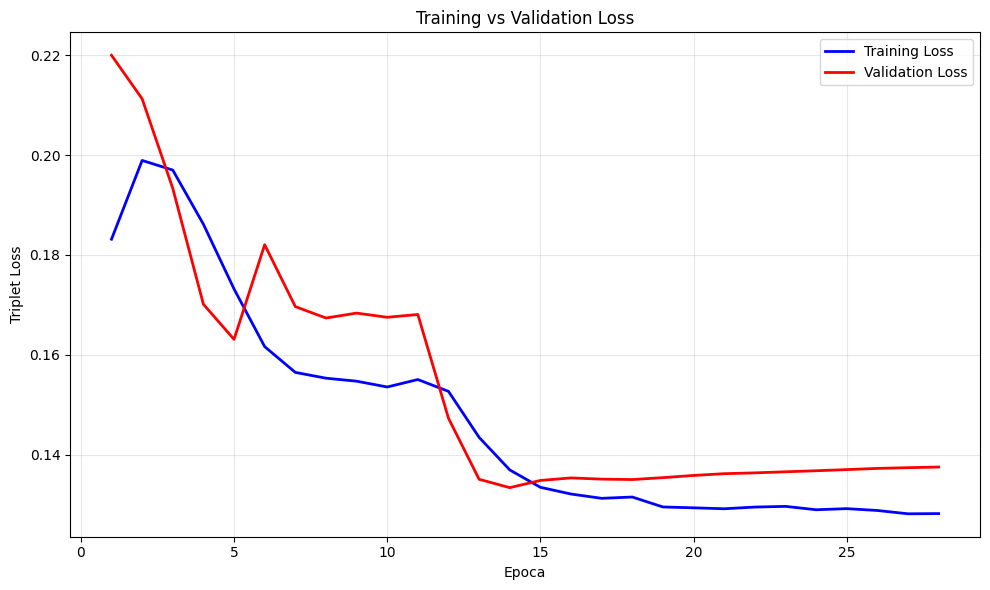

Estrazione delle feature finali dal modello addestrato


Estrazione features test: 100%|██████████| 24/24 [00:00<00:00, 592.29it/s]


[INFO] Risultati SVM:
Training
Classe Real: 
Precision = 96.5825%
 Recall = 93.4435% 
F1 = 94.9871%
---------------------------------
Training
Classe Fake: 
Precision = 93.6511%
 Recall = 96.6942% 
F1 = 95.1483%
---------------------------------
---------------------------------

[INFO] Accuracy SVM Training: 95.0690
[INFO] F1 Score Training: 95.0677
[INFO] Precision Training: 95.1167
[INFO] Recall Training: 95.0690
[INFO] Classification Report Training:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5323
           1       0.94      0.97      0.95      5324

    accuracy                           0.95     10647
   macro avg       0.95      0.95      0.95     10647
weighted avg       0.95      0.95      0.95     10647

[INFO] Confusion Matrix Training:
[[4974  349]
 [ 176 5148]]
[INFO] Risultati SVM:
Validation
Classe Real: 
Precision = 97.3464%
 Recall = 91.5900% 
F1 = 94.3805%
---------------------------------
Validation
Classe

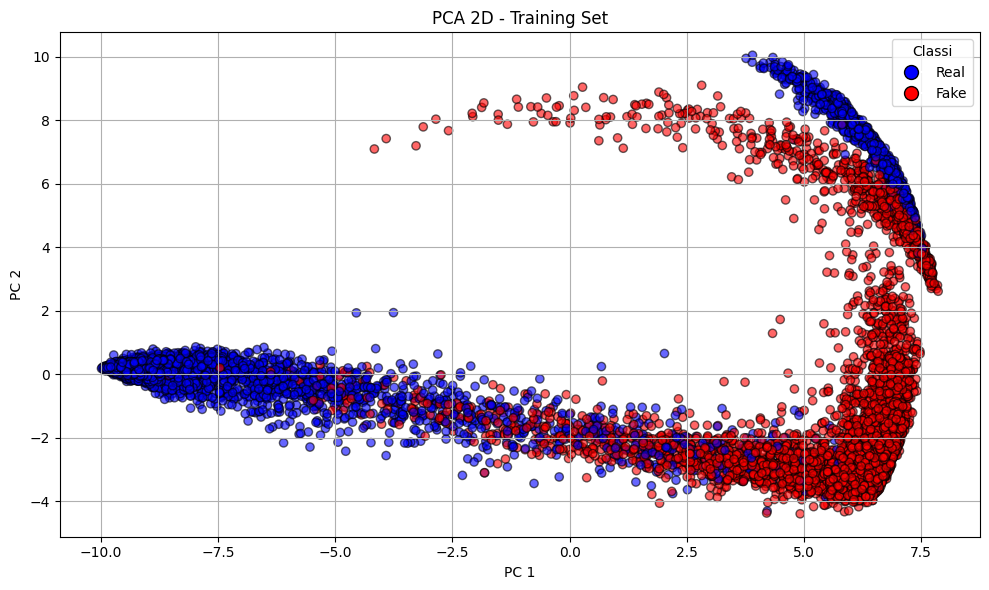

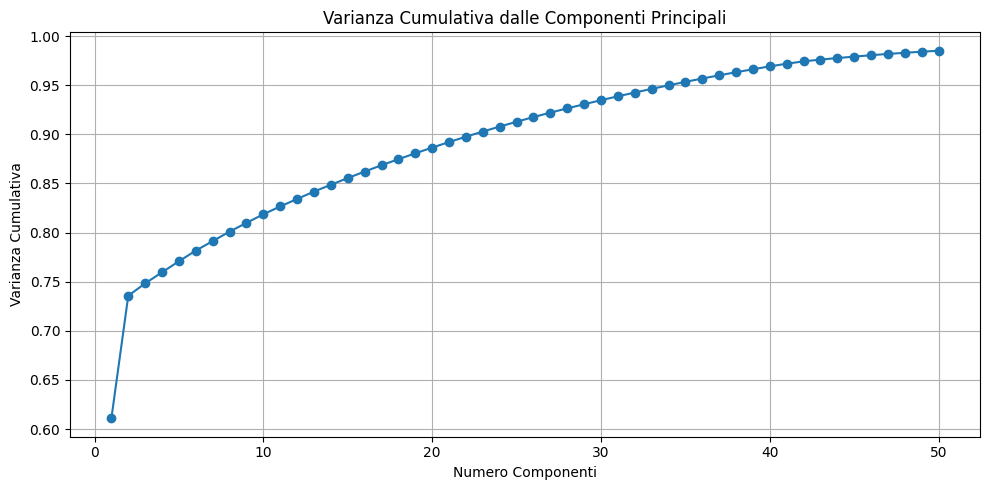

In [92]:
# Impostazione del dispositivo e caricamento del modello CLIP
print("Setup del dispositivo")
device = setup_device()


# Carica il modello CLIP pre-addestrato
print("Caricamento del modello CLIP")
model, preprocess = clip.load("ViT-B/16", device=device)


# Caricamento del dataset e degli embedding delle immagini
current_dir = Path(os.getcwd())
project_dir = current_dir.parent
csv_path = project_dir / "dataset" / "cycle_gan" / "metadata.csv"


# Carica il dataset e gli embedding delle immagini
print("Caricamento del dataset e degli embedding delle immagini")
dataset, X_img, y_img = load_dataset_and_embeddings(metadata_index=5, csv_path=csv_path)


# Estrazione degli embedding testuali per le categorie
print("Estrazione degli embedding testuali per le categorie")
category_embeddings = extract_text_embeddings(dataset)


# Preparazione dei DataLoader per training, validation e test
train_loader, val_loader, test_loader = prepare_dataloaders(dataset, X_img, y_img, category_embeddings)


# Creazione del modello multimodale e addestramento
print("Creazione del modello multimodale ImageTextModel")
image_text_model = ImageTextModel().to(device)


# Addestramento del modello con triplet loss
print("Inizio dell'addestramento del modello")
train_losses, val_losses = train_model(image_text_model, train_loader, val_loader, device)


# Visualizzazione della loss di training e validation
print("Visualizzazione della loss di training e validation")
plot_triplet_loss(train_losses, val_losses)


# Estrazione delle feature finali dal modello addestrato
print("Estrazione delle feature finali dal modello addestrato")
features = extract_final_features(image_text_model, [train_loader, val_loader, test_loader], device)


# Addestramento e valutazione del classificatore SVM sulle feature estratte
train_and_evaluate_svm(*features['train'], *features['val'], *features['test'])


# Proiezione PCA 2D delle feature del training set
plot_pca_2d(features['train'][0], features['train'][1], title="PCA 2D - Training Set")